[The Stanford Open Policing Project](https://openpolicing.stanford.edu/)

On a typical day in the United States, police officers make more than 50,000 traffic stops. The project collects and standardize data on vehicle and pedestrian stops from law enforcement departments across the country. The current dataset is a subset comprising only the Rhode Island County. 

The current analysis is based on the Course - [Analyzing Police Activity with Pandas](  https://campus.datacamp.com/courses/analyzing-police-activity-with-pandas)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
import matplotlib.pyplot as plt
from pprint import pprint as pp

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
%matplotlib inline

/kaggle/input/stanford-open-policing-project/police_project.csv


# 1. Preparing the data for analysis


Before beginning your analysis, it is critical that you first examine and clean the dataset, to make working with it a more efficient process. Let's practice fixing data types, handling missing values, and dropping columns and rows while learning about the Stanford Open Policing Project dataset.

In [2]:
INPUT = '/kaggle/input/stanford-open-policing-project/police_project.csv'


# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

df = pd.read_csv(INPUT)

df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91741 entries, 0 to 91740
Data columns (total 15 columns):
stop_date             91741 non-null object
stop_time             91741 non-null object
county_name           0 non-null float64
driver_gender         86406 non-null object
driver_age_raw        86414 non-null float64
driver_age            86120 non-null float64
driver_race           86408 non-null object
violation_raw         86408 non-null object
violation             86408 non-null object
search_conducted      91741 non-null bool
search_type           3196 non-null object
stop_outcome          86408 non-null object
is_arrested           86408 non-null object
stop_duration         86408 non-null object
drugs_related_stop    91741 non-null bool
dtypes: bool(2), float64(3), object(10)
memory usage: 9.3+ MB


The [pandas_profiling](https://pandas-profiling.github.io/pandas-profiling/docs/) eliminates a lot of the pain in EDA. 

In [4]:
df.profile_report(style={'full_width':True})

/opt/conda/lib/python3.6/site-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 1).')
  correlation_name=correlation_name, error=error


The `pandas_profiling` report did the most heavy lifting for us, but let's try to replicate from scratch some of it as an exercise.

In [5]:
df.shape

(91741, 15)

The method `df.isnull()` creates a dataframe of boolean values, where `True` is for missing values and `False`otherwise. Since in python `True == 1` and `False == 0` we can count the missing values by summing this dataframe of boolean values. This will return a series counting the missing values per column.

In [6]:
df.isnull().sum()

stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5335
driver_age_raw         5327
driver_age             5621
driver_race            5333
violation_raw          5333
violation              5333
search_conducted          0
search_type           88545
stop_outcome           5333
is_arrested            5333
stop_duration          5333
drugs_related_stop        0
dtype: int64

## Dropping Columns

1. The column `county_name` is exclusively missing values, maybe because this is a subset from the original dataset comprising one specific state `Rhode Island`, so this column has no information and we can safely drop it.

In [7]:
df.drop('county_name', axis='columns', inplace=True)

## Dropping Rows
One interesting analysis is to compare outcomes by gender, so the gender information might be critical and it makes sense to drop the rows missing the gender, since the number is small `5.8%`

In [8]:
df.dropna(subset=['driver_gender'], inplace=True)
df.isnull().sum()

stop_date                 0
stop_time                 0
driver_gender             0
driver_age_raw            1
driver_age              293
driver_race               0
violation_raw             0
violation                 0
search_conducted          0
search_type           83210
stop_outcome              0
is_arrested               0
stop_duration             0
drugs_related_stop        0
dtype: int64

After eliminating the records with `NULL` values in `driver_gender`,  we pretty much eliminated almost all `NULL` values in the dataset, let's fill the remaining `NULL` values in `driver_age` with the average age so we can properly define the datatypes.

In [9]:
df.loc[df.driver_age.isnull(), ['driver_age']] = int(df.driver_age.mean())
df.loc[df.driver_age_raw.isnull(), ['driver_age_raw']] = int(df.driver_age_raw.mean())

## Proper Datatypes
The `pandas_profiling` also gaves us everything we need to define the correct datatypes.
Pandas infer datatypes upon loading but usually is not very efficient, datatypes are important because it affects which operations can be performed on it and usually we can be way more efficient (i.e. less memory and faster loading types) if we properly set the datatypes. The current dataframe occupies `8.7MB` in memory, let's see how we can lower it only by defining the correct datatypes.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86406 entries, 0 to 91740
Data columns (total 14 columns):
stop_date             86406 non-null object
stop_time             86406 non-null object
driver_gender         86406 non-null object
driver_age_raw        86406 non-null float64
driver_age            86406 non-null float64
driver_race           86406 non-null object
violation_raw         86406 non-null object
violation             86406 non-null object
search_conducted      86406 non-null bool
search_type           3196 non-null object
stop_outcome          86406 non-null object
is_arrested           86406 non-null object
stop_duration         86406 non-null object
drugs_related_stop    86406 non-null bool
dtypes: bool(2), float64(2), object(10)
memory usage: 8.7+ MB


* `object`: Python objects  - Strings, Lists, etc
    * Large Space and limited operations, avoid whenever possible
* `bool`: `True` and `False` values. 
    * 1 byte - Logical and Mathematical Operations
* `int, float`
    * enables math operations
* `datetime`
    * enables different date attributes such as day, month, year 
    * methods to slice and resample, not possible with strings
* `category`
    * uses less memory and runs faster


In [11]:
# When assigning to columns, only the square brackets notation works.
df['is_arrested'] = df.is_arrested.astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86406 entries, 0 to 91740
Data columns (total 14 columns):
stop_date             86406 non-null object
stop_time             86406 non-null object
driver_gender         86406 non-null object
driver_age_raw        86406 non-null float64
driver_age            86406 non-null float64
driver_race           86406 non-null object
violation_raw         86406 non-null object
violation             86406 non-null object
search_conducted      86406 non-null bool
search_type           3196 non-null object
stop_outcome          86406 non-null object
is_arrested           86406 non-null bool
stop_duration         86406 non-null object
drugs_related_stop    86406 non-null bool
dtypes: bool(3), float64(2), object(9)
memory usage: 8.2+ MB


* The `driver_age`goes from 15 to 88, so a `int8/uint8` ( 1 byte of memory, range between -128/127 or 0/255 ) is sufficient.
* The `driver_age_raw` are year values so a `int16/float16` (2 bytes of memory, range between -32768 and 32767 or 0/65535) is sufficient. 

[More info here](https://medium.com/@vincentteyssier/optimizing-the-size-of-a-pandas-dataframe-for-low-memory-environment-5f07db3d72e)

In [12]:
df['driver_age'] = df['driver_age'].astype('int8')
df['driver_age_raw'] = df['driver_age_raw'].astype('int16')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86406 entries, 0 to 91740
Data columns (total 14 columns):
stop_date             86406 non-null object
stop_time             86406 non-null object
driver_gender         86406 non-null object
driver_age_raw        86406 non-null int16
driver_age            86406 non-null int8
driver_race           86406 non-null object
violation_raw         86406 non-null object
violation             86406 non-null object
search_conducted      86406 non-null bool
search_type           3196 non-null object
stop_outcome          86406 non-null object
is_arrested           86406 non-null bool
stop_duration         86406 non-null object
drugs_related_stop    86406 non-null bool
dtypes: bool(3), int16(1), int8(1), object(9)
memory usage: 7.1+ MB


For the remaining categorical datatypes:

In [13]:
for col in ['driver_gender', 'driver_race', 'violation_raw', 'violation', 'stop_outcome']:
    df[col] = df[col].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86406 entries, 0 to 91740
Data columns (total 14 columns):
stop_date             86406 non-null object
stop_time             86406 non-null object
driver_gender         86406 non-null category
driver_age_raw        86406 non-null int16
driver_age            86406 non-null int8
driver_race           86406 non-null category
violation_raw         86406 non-null category
violation             86406 non-null category
search_conducted      86406 non-null bool
search_type           3196 non-null object
stop_outcome          86406 non-null category
is_arrested           86406 non-null bool
stop_duration         86406 non-null object
drugs_related_stop    86406 non-null bool
dtypes: bool(3), category(5), int16(1), int8(1), object(4)
memory usage: 4.2+ MB


By just defining the proper datatypes we went from `8.7MB` to `4.2MB` 

## Creating a Datetime Index
Let's combine the `stop_date` and `stop_time` columns to create a `datetime` column. In the datetime format the date and time are separated by a space.

In [14]:
datetime = df.stop_date.str.cat(df.stop_time, sep= ' ')
df['stop_datetime'] = pd.to_datetime(datetime)

Now that we have a datetime column, we can define it as the DataFrame's index. By doing this we can easily slice, subset and analyze the data by date and time.

In [15]:
df.set_index('stop_datetime', inplace=True)
df.head()

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
stop_datetime,,,,,,,,,,,,,,
2005-01-02 01:55:00,2005-01-02,01:55,M,1985,20,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-01-18 08:15:00,2005-01-18,08:15,M,1965,40,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-01-23 23:15:00,2005-01-23,23:15,M,1972,33,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-02-20 17:15:00,2005-02-20,17:15,M,1986,19,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
2005-03-14 10:00:00,2005-03-14,10:00,F,1984,21,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [16]:
# Now we can drop the redundant columns
df.drop(['stop_date', 'stop_time'], axis='columns', inplace=True)
df.head()

,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
stop_datetime,,,,,,,,,,,,
2005-01-02 01:55:00,M,1985,20,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-01-18 08:15:00,M,1965,40,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-01-23 23:15:00,M,1972,33,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-02-20 17:15:00,M,1986,19,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
2005-03-14 10:00:00,F,1984,21,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


# Analysing Outcomes by Gender

## Counting Unique values
 * `value_counts()`: returns a Series with the distint unique values for each column

In [17]:
df.stop_outcome.value_counts()

Citation            77005
Warning              5293
Arrest Driver        2571
N/D                   590
No Action             589
Arrest Passenger      358
Name: stop_outcome, dtype: int64

In [18]:
# Percentage from the total
df.stop_outcome.value_counts() / df.shape[0]

Citation            0.891
Warning             0.061
Arrest Driver       0.030
N/D                 0.007
No Action           0.007
Arrest Passenger    0.004
Name: stop_outcome, dtype: float64

In [19]:
# As usual there is a method which do that for us
df.stop_outcome.value_counts(normalize=True)

Citation            0.891
Warning             0.061
Arrest Driver       0.030
N/D                 0.007
No Action           0.007
Arrest Passenger    0.004
Name: stop_outcome, dtype: float64

In [20]:
df.driver_race.value_counts()

White       62156
Black       12244
Hispanic     9507
Asian        2259
Other         240
Name: driver_race, dtype: int64

## Filtering by Gender

In [21]:
male = df[df.driver_gender == 'M']
female = df[df.driver_gender == 'F']

print("Female Violations")
pp(female.violation.value_counts(normalize=True))

print("\nMale Violations")
pp(male.violation.value_counts(normalize=True))


Female Violations
Speeding               0.659
Moving violation       0.136
Equipment              0.106
Registration/plates    0.043
Other                  0.029
Seat belt              0.027
Name: violation, dtype: float64

Male Violations
Speeding               0.524
Moving violation       0.207
Equipment              0.136
Other                  0.058
Registration/plates    0.038
Seat belt              0.037
Name: violation, dtype: float64


About two-thirds of female traffic stops are for speeding, whereas for males is about half. This doesn't mean that females speed more often than males, however, since we didn't take into account the number of stops or drivers.

In [22]:
print(f"Female Records: {female.shape[0]}\nMale Records: {male.shape[0]}")

Female Records: 23511
Male Records: 62895


## Filtering by multiple Conditions
When filtering by multiple conditions, inside the brackets the conditions are enclosed by parenthesis and the logical operators are *C* like instead:
* `&`: represents the `and` operation
* `|`: represents the `or` operation

In [23]:
arrested_females = df[(df.driver_gender == 'F') & (df.is_arrested == True)]
arrested_males = df[(df.driver_gender == 'M') & (df.is_arrested == True)]

In [24]:
print(f"Arrested Females: {arrested_females.shape[0]}\nArrested Males: {arrested_males.shape[0]}")

Arrested Females: 596
Arrested Males: 2333


## Speeding outcomes

When a driver is pulled over for speeding, many people believe that gender has an impact on whether the driver will receive a ticket or a warning. 

In [25]:
female_and_speeding = df[(df.driver_gender == 'F') & (df.violation == 'Speeding')]
male_and_speeding = df[(df.driver_gender == 'M') & (df.violation == 'Speeding')]

print("Female Outcomes After Speeding")
print(female_and_speeding.stop_outcome.value_counts(normalize=True))
print("\nMale Outcomes After Speeding")
print(male_and_speeding.stop_outcome.value_counts(normalize=True))

Female Outcomes After Speeding
Citation            9.526e-01
Warning             3.992e-02
Arrest Driver       5.361e-03
N/D                 8.397e-04
Arrest Passenger    8.397e-04
No Action           4.521e-04
Name: stop_outcome, dtype: float64

Male Outcomes After Speeding
Citation            0.946
Warning             0.035
Arrest Driver       0.015
Arrest Passenger    0.001
No Action           0.001
N/D                 0.001
Name: stop_outcome, dtype: float64


The Proportions of Citations ( Ticket ) and Warning doesn't seem any different for different genders.

## Search Rate

During a traffic stop, the police officer sometimes conducts a search of the vehicle. In this exercise, you'll calculate the percentage of all stops that result in a vehicle search, also known as the search rate.

In [26]:
print(df.search_conducted.dtype)
print(df.search_conducted.value_counts(normalize=True))

print("\nPercentage of Searched Vehicles:")
print(f'{df.search_conducted.mean() * 100:.2f}%')

bool
False    0.963
True     0.037
Name: search_conducted, dtype: float64

Percentage of Searched Vehicles:
3.70%


In [27]:
print("\nPercentage of Searched Vehicles (Female):")

print(f"{df[df.driver_gender == 'F'].search_conducted.mean() * 100:.2f}%")

print("\nPercentage of Searched Vehicles (Male):")

print(f"{df[df.driver_gender == 'M'].search_conducted.mean() * 100:.2f}%")


Percentage of Searched Vehicles (Female):
2.00%

Percentage of Searched Vehicles (Male):
4.33%


A better way to do this is aggregate using the groupby method:

In [28]:
print("\nSearched Vehicles by gender:")

df.groupby('driver_gender').search_conducted.mean()


Searched Vehicles by gender:


driver_gender
F    0.020
M    0.043
Name: search_conducted, dtype: float64

## Adding a second factor to the analysis

Even though the search rate for males is much higher than for females, it's possible that the difference is mostly due to a second factor.

For example, you might hypothesize that the search rate varies by violation type, and the *difference in search rate between males and females is because they tend to commit different violations.*

You can test this hypothesis by examining the search rate for each combination of gender and violation. If the hypothesis was true, you would find that males and females are searched at about the same rate for each violation

In [29]:
print(df.groupby(['violation', 'driver_gender']).search_conducted.mean())

violation            driver_gender
Equipment            F                0.043
                     M                0.070
Moving violation     F                0.036
                     M                0.060
Other                F                0.057
                     M                0.047
Registration/plates  F                0.066
                     M                0.110
Seat belt            F                0.013
                     M                0.038
Speeding             F                0.009
                     M                0.025
Name: search_conducted, dtype: float64


The search rate is higher for males than for females for all types of specified violations, disproving our hypothesis, at least for this dataset.

## Protective Frisks
During a vehicle search, the police officer may pat down the driver to check if they have a weapon. This is known as a "protective frisk."

In [30]:
print(df.search_type.value_counts())

# Check if 'search_type' contains the string 'Protective Frisk'
df['frisk'] = df.search_type.str.contains('Protective Frisk', na=False)

# Take the sum of 'frisk'
print(df.frisk.sum())

Incident to Arrest                                          1219
Probable Cause                                               891
Inventory                                                    220
Reasonable Suspicion                                         197
Protective Frisk                                             161
Incident to Arrest,Inventory                                 129
Incident to Arrest,Probable Cause                            106
Probable Cause,Reasonable Suspicion                           75
Incident to Arrest,Inventory,Probable Cause                   34
Probable Cause,Protective Frisk                               33
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      22
Incident to Arrest,Reasonable Suspicion                       13
Inventory,Protective Frisk                                    11
Incident to Arrest,Inventory,Protective Frisk                 11
Protective Frisk,Reasonab

In [31]:
searched = df[df.search_conducted == True]

print(searched.frisk.mean())

# Calculate the frisk rate for each gender
print(searched.groupby('driver_gender').frisk.mean())

0.08573216520650813
driver_gender
F    0.062
M    0.090
Name: frisk, dtype: float64


Males are frisked more often than females, though we can't conclude that this difference is caused by the driver's gender.

# Adding some Visualizations
## Calculating the hourly arrest rate

When a police officer stops a driver, a small percentage of those stops ends in an arrest. This is known as the arrest rate. Let's check whether the arrest rate varies by time of day.

    0 = midnight
    12 = noon
    23 = 11 PM


In [32]:
print(f"Mean of Arrests: {df.is_arrested.mean():.3f}")
print("Hourly Arrest Rates")
hourly_arrest_rate = df.groupby(df.index.hour).is_arrested.mean()
pp(hourly_arrest_rate)

Mean of Arrests: 0.034
Hourly Arrest Rates
stop_datetime
0     0.047
1     0.061
2     0.063
3     0.053
4     0.074
5     0.032
6     0.014
7     0.013
8     0.020
9     0.025
10    0.025
11    0.027
12    0.033
13    0.030
14    0.033
15    0.032
16    0.031
17    0.033
18    0.044
19    0.032
20    0.041
21    0.054
22    0.043
23    0.043
Name: is_arrested, dtype: float64


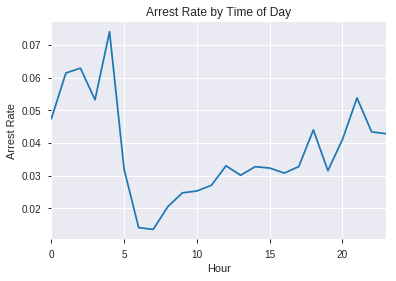

In [33]:
hourly_arrest_rate.plot()

# Add the xlabel, ylabel, and title
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')

# Display the plot
plt.show()

The arrest rate has a significant spike overnight, and then dips in the early morning hours.

## Plotting drug-related stops

In a small portion of traffic stops, drugs are found in the vehicle during a search.

The Boolean column drugs_related_stop indicates whether drugs were found during a given stop. 

Let's resample this column by year to see the trend

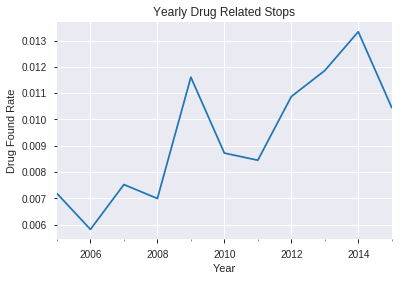

In [34]:
annual_drug_rate = df.drugs_related_stop.resample("A").mean()

annual_drug_rate.plot()
plt.xlabel('Year')
plt.ylabel('Drug Found Rate')
plt.title('Yearly Drug Related Stops')
plt.show()

The rate of drug-related stops nearly double in 10 years - 2005-2015

Let's see if this increase is correlated with the search rate.

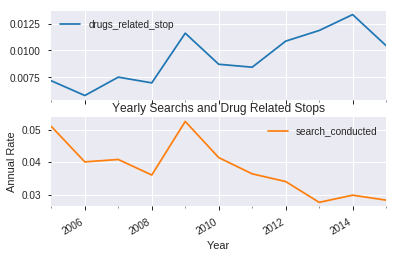

In [35]:
annual_search_rate = df.search_conducted.resample('A').mean()

annual = pd.concat([annual_drug_rate, annual_search_rate], axis=1)

annual.plot(subplots=True)
plt.xlabel('Year')
plt.ylabel('Annual Rate')
plt.title('Yearly Searchs and Drug Related Stops')
plt.show()

Actually the `search_conducted` appears to be inversally correlated, contrary to our hypotheses

## Violations by Race
*  * **Frequency Table** It shows how many times each combination of values occurs

In [36]:
table = pd.crosstab(df.driver_race, df.violation)
table

violation,Equipment,Moving violation,Other,Registration/plates,Seat belt,Speeding
driver_race,,,,,,
Asian,201,334,82,58,58,1526
Black,2202,2883,887,784,450,5038
Hispanic,2146,2408,593,716,551,3093
Other,16,52,21,2,2,147
White,6455,10547,2734,1872,1891,38657


In [37]:
table = pd.crosstab(df.driver_race, df.violation, normalize=True)
table

violation,Equipment,Moving violation,Other,Registration/plates,Seat belt,Speeding
driver_race,,,,,,
Asian,2.326e-03,3.865e-03,9.490e-04,6.712e-04,6.712e-04,0.018
Black,2.548e-02,3.337e-02,1.027e-02,9.073e-03,5.208e-03,0.058
Hispanic,2.484e-02,2.787e-02,6.863e-03,8.286e-03,6.377e-03,0.036
Other,1.852e-04,6.018e-04,2.430e-04,2.315e-05,2.315e-05,0.002
White,7.471e-02,1.221e-01,3.164e-02,2.167e-02,2.189e-02,0.447


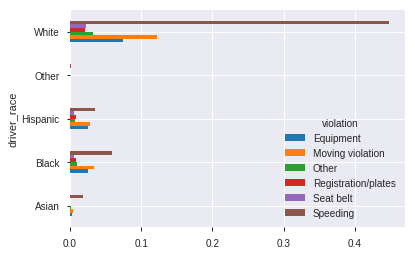

In [38]:
table.plot(kind='barh')
plt.show()

All the numbers for `Whites` are higher because there are a lot more stops of whites, probably because there are a lot more of them. We can't conclude much from this race difference, this plot was only to ilustrate the use of Frequency Table.

## How long might you be stopped for a violation?
The `stop_duration` column tells you approximatelly how long the driver was detained by the officer. Since the durations are stored as strings and it's an approximation, we must map to an estimated number to get any useful insight.

<ul>
<li>Convert <code>'0-15 Min'</code> to <code>8</code></li> 
<li>Convert <code>'16-30 Min'</code> to <code>23</code></li>
<li>Convert <code>'30+ Min'</code> to <code>45</code></li>
</ul>

In [39]:
print(df.stop_duration.unique())

# Create a dictionary that maps strings to integers
mapping = {'0-15 Min': 8, '16-30 Min': 23, '30+ Min': 45}

# Convert the 'stop_duration' strings to integers using the 'mapping'
df['stop_minutes'] =df.stop_duration.map(mapping)
print(df.stop_minutes.unique())

['0-15 Min' '16-30 Min' '30+ Min' '2' '1']
[ 8. 23. 45. nan]


There are 2 single records, '2' and '1', which are not clear what they mean, so we don't map them. This turns them into `nan` so we can safely discard.  

In [40]:
df.dropna(subset=['stop_minutes'], inplace=True)

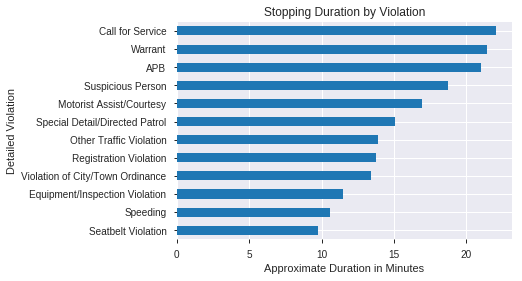

In [41]:
stop_length = df.groupby('violation_raw').stop_minutes.mean()
stop_length.sort_values().plot(kind='barh')

plt.xlabel('Approximate Duration in Minutes')
plt.ylabel('Detailed Violation')
plt.title("Stopping Duration by Violation")
plt.show()

That's it for now. It's just a little exploration of data using just pandas. 